In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import re

In [2]:
##################################################
####### import function 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


## Figure S106

In [3]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

filelist = ['CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls',
           'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls',
           'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls',
           'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls',
           'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls',
           'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls',
           'Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls']

# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls':{'color':'b', 'name':'CAU-10-H'},
                             'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls':{'color':'r', 'name':'MIL-160'},
                            'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls':{'color':'grey', 'name':'Syloid'},
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls read succesfull
File MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls read succesfull
File MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls read succesfull
File ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls read succesfull
File ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls read succesfull
File ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls read succesfull
File Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls read succesfull


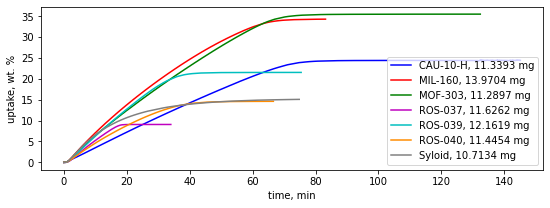

In [4]:
fig = plt.figure(figsize=(9, 3))
for m, Sorption in enumerate(Water_Sorption_list):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
    plt.plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
             Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
             c=name_and_color_dictionary[Sorption.filename]['color'],
             label=''.join([name_and_color_dictionary[Sorption.filename]['name'], 
                            ', ',#.ljust(6-len([name_and_color_dictionary[Sorption.filename]['name']])), 
                            str(Sorption.sample_mass), ' mg' ]))
plt.legend()
plt.xlabel('time, min')
plt.ylabel('uptake, wt. %')
plt.savefig('Figure1a.png', dpi=300)
plt.show()

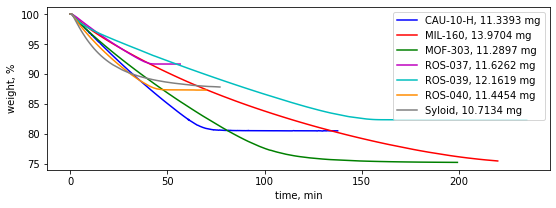

In [5]:
fig = plt.figure(figsize=(9, 3))
for m, Sorption in enumerate(Water_Sorption_list):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
    plt.plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(), 
             (Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['mass']/Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['mass'].max())*100 , 
             
             c=name_and_color_dictionary[Sorption.filename]['color'],
             label=''.join([name_and_color_dictionary[Sorption.filename]['name'], 
                            ', ',#.ljust(6-len([name_and_color_dictionary[Sorption.filename]['name']])), 
                            str(Sorption.sample_mass), ' mg' ]))
plt.legend()
plt.xlabel('time, min')
plt.ylabel('weight, %')
plt.savefig('Figure1b_weight.png', dpi=300)
plt.show()

## Figure S105

In [6]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/different_packing/'

filelist = ['ROS037_TGApan_u50-150_PackedByKnocking_4mg-2021-04-01 19-41-38.xls',
           'ROS037_TGApan_u50-150_PackedByKnocking_6mg-2021-04-01 19-41-38.xls',
           'ROS037_TGApan_u50-150_PackedByKnocking_8mg-2021-04-02 17-18-39.xls',
           'ROS037_TGApan_u50-150_PackedByKnocking_14mg-2021-04-02 17-18-39.xls',
           'ROS037NMRcap_u50-150_rePackedByKnocking_nearlyfull-2021-04-06 12-49-19.xls',
           
           ]

# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls':{'color':'b', 'name':'CAU-10-H'},
                             'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls':{'color':'r', 'name':'MIL-160'},
                            'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls':{'color':'grey', 'name':'Syloid'},
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File ROS037_TGApan_u50-150_PackedByKnocking_4mg-2021-04-01 19-41-38.xls read succesfull
File ROS037_TGApan_u50-150_PackedByKnocking_6mg-2021-04-01 19-41-38.xls read succesfull
File ROS037_TGApan_u50-150_PackedByKnocking_8mg-2021-04-02 17-18-39.xls read succesfull
File ROS037_TGApan_u50-150_PackedByKnocking_14mg-2021-04-02 17-18-39.xls read succesfull
File ROS037NMRcap_u50-150_rePackedByKnocking_nearlyfull-2021-04-06 12-49-19.xls read succesfull


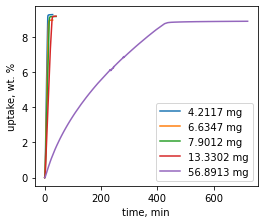

In [8]:
fig = plt.figure(figsize=(4, 3.3))
for m, Sorption in enumerate(Water_Sorption_list[:]):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
    plt.plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
             Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
             #c=name_and_color_dictionary[Sorption.filename]['color'],
             label=''.join([str(Sorption.sample_mass), ' mg' ]))
plt.legend()
plt.xlabel('time, min')
plt.ylabel('uptake, wt. %')
plt.savefig('FigureDifferentPackings+NMR.png', dpi=300)
plt.show()